In [773]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras import regularizers

In [774]:
wine_ds = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

In [775]:
df = pd.read_csv(wine_ds, delimiter=";")

In [776]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [777]:
# split the data such as 60% as training set, 20% for each set the validation set and test set
train, validate, test = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])
# make sure everything works 
len(df) == len(train) + len(validate) + len(test)

True

In [778]:
train_input, train_label = train.iloc[:,:-1], train.iloc[:,-1:]
validate_input, validate_label = validate.iloc[:,:-1], validate.iloc[:,-1:]
test_input, test_label = test.iloc[:,:-1], test.iloc[:,-1:]
# make sure everything works 
train_input.shape[1] == 11, train_label.shape[1] == 1

(True, True)

## Build Tensorflow Datasets [source](https://medium.com/when-i-work-data/converting-a-pandas-dataframe-into-a-tensorflow-dataset-752f3783c168)

In [779]:
train_tfds = (tf.data.Dataset.from_tensor_slices((
            tf.cast(train_input[train_input.columns].values, tf.float32),
            tf.cast(train_label.values, tf.uint8))))

validate_tfds = (tf.data.Dataset.from_tensor_slices((
            tf.cast(validate_input[validate_input.columns].values, tf.float32),
            tf.cast(validate_label.values, tf.uint8))))

test_tfds = (tf.data.Dataset.from_tensor_slices((
            tf.cast(test_input[test_input.columns].values, tf.float32),
            tf.cast(test_label.values, tf.uint8))))


### find the median of the labels to create a "decent" threshold

In [780]:
train_median = []
for features_tensor, target_tensor in train_tfds:
    train_median.append(target_tensor)

validate_median = []
for features_tensor, target_tensor in validate_tfds:
    validate_median.append(target_tensor)

test_median = []
for features_tensor, target_tensor in test_tfds:
    test_median.append(target_tensor)
    
print(np.median(test_median))
np.median(test_median) == np.median(validate_median) == np.median(train_median)



6.0


True

In [781]:
thershold = np.median(test_median) 
def make_binary(target):
    if target >= thershold: 
        return tf.constant(1, dtype=tf.float32)
    return tf.constant(0, dtype=tf.float32)

def make_binary_normalised(target):
    threshold = tf.constant(0.6, dtype=tf.float32)
    if float(target) >= threshold: 
        return tf.constant(1, dtype=tf.float32)
    return tf.constant(0, dtype=tf.float32)

## Create Normalised Input

In [782]:
# normalize only input, whose values are not between 0 and 1
x = df[['fixed acidity','residual sugar', 'free sulfur dioxide', 'total sulfur dioxide','pH', 'alcohol', 'quality']].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_normalised = pd.DataFrame(x_scaled)
df_normalised.columns = ['fixed acidity','residual sugar', 'free sulfur dioxide', 'total sulfur dioxide','pH', 'alcohol', 'quality']
df_normalised['volatile acidity'] = df['volatile acidity']
df_normalised['chlorides'] = df['chlorides']
df_normalised['citric acid'] = df['citric acid']
df_normalised['density'] = df['density']
df_normalised['sulphates'] = df['sulphates']
df_normalised = df_normalised[['fixed acidity','volatile acidity','citric acid','residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide','density','pH','sulphates', 'alcohol', 'quality']]


train_norm, validate_norm, test_norm = np.split(df_normalised.sample(frac=1, random_state=42), [int(.6*len(df_normalised)), int(.8*len(df_normalised))])

train_input_norm, train_label_norm = train_norm.iloc[:,:-1], train_norm.iloc[:,-1:]
validate_input_norm, validate_label_norm = validate_norm.iloc[:,:-1], validate_norm.iloc[:,-1:]
test_input_norm, test_label_norm = test_norm.iloc[:,:-1], test_norm.iloc[:,-1:]


train_tfds_norm = (tf.data.Dataset.from_tensor_slices((
            tf.cast(train_input_norm[train_input_norm.columns].values, tf.float32),
            tf.cast(train_label_norm.values, tf.float32))))

validate_tfds_norm = (tf.data.Dataset.from_tensor_slices((
            tf.cast(validate_input_norm[validate_input_norm.columns].values, tf.float32),
            tf.cast(validate_label_norm.values, tf.float32))))

test_tfds_norm = (tf.data.Dataset.from_tensor_slices((
            tf.cast(test_input_norm[test_input_norm.columns].values, tf.float32),
            tf.cast(test_label_norm.values, tf.float32))))

In [783]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [784]:
df_normalised.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,0.329171,0.527821,0.270976,0.112247,0.087467,0.209506,0.142996,0.996747,0.449695,0.658149,0.311228,0.527205
std,0.154079,0.179060,0.194801,0.096570,0.047065,0.147326,0.116238,0.001887,0.121564,0.169507,0.163949,0.161514
min,0.000000,0.120000,0.000000,0.000000,0.012000,0.000000,0.000000,0.990070,0.000000,0.330000,0.000000,0.000000
25%,0.221239,0.390000,0.090000,0.068493,0.070000,0.084507,0.056537,0.995600,0.370079,0.550000,0.169231,0.400000
50%,0.292035,0.520000,0.260000,0.089041,0.079000,0.183099,0.113074,0.996750,0.448819,0.620000,0.276923,0.600000
75%,0.407080,0.640000,0.420000,0.116438,0.090000,0.281690,0.197880,0.997835,0.519685,0.730000,0.415385,0.600000
max,1.000000,1.580000,1.000000,1.000000,0.611000,1.000000,1.000000,1.003690,1.000000,2.000000,1.000000,1.000000


In [785]:
# credits to group 2 ^.^
batch_size = 32
shuffle = 1000
prefetch_data = 50

def preprocessing(ds):
    global batch_size, shuffle, prefetch_data
    ds = ds.map(lambda feature, label: (feature, make_binary(label)))

    ds = ds.cache()
    ds = ds.shuffle(shuffle)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(100)
    return ds

def preprocessing_normalised(ds):
    global batch_size, shuffle
    ds = ds.map(lambda feature, label: (feature, make_binary_normalised(label)))

    ds = ds.cache()
    ds = ds.shuffle(shuffle)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(prefetch_data)
    return ds


In [786]:
def change_batch_size(batch_sz, shuff, prefetch):
    """needed when the batch size is changed"""
    global train_ds, validate_ds, test_ds
    global train_ds_norm, validate_ds_norm
    global batch_size, shuffle, prefetch_data, test_ds_norm
    
    batch_size = batch_sz
    shuffle = shuff
    prefetch_data = prefetch
    
    train_ds = train_tfds.apply(preprocessing)
    validate_ds = validate_tfds.apply(preprocessing)
    test_ds = test_tfds.apply(preprocessing)

    train_ds_norm = train_tfds_norm.apply(preprocessing_normalised)
    validate_ds_norm = validate_tfds_norm.apply(preprocessing_normalised)
    test_ds_norm = test_tfds_norm.apply(preprocessing_normalised)


In [824]:
# initalize them first
train_ds = train_tfds.apply(preprocessing)
validate_ds = validate_tfds.apply(preprocessing)
test_ds = test_tfds.apply(preprocessing)

train_ds_norm = train_tfds_norm.apply(preprocessing_normalised)
validate_ds_norm = validate_tfds_norm.apply(preprocessing_normalised)
test_ds_norm = test_tfds_norm.apply(preprocessing_normalised)

## Model and Layer of last week's assigment of group 2

In [825]:
# credits to group 2!
class DenseLayer(tf.keras.layers.Layer):
    def __init__(self, units, activation, kernel_regularizer = None):

        super(DenseLayer, self).__init__(kernel_regularizer)
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', trainable=True)
        self.b= self.add_weight(shape=(self.units,), initializer='random_normal', trainable=True)

    def call(self, inputs):
        """Compute forward pass through layer."""
        x = tf.matmul(inputs, self.w) + self.b
        x = self.activation(x)
        return x

In [789]:
class MyModel(tf.keras.Model):
    def __init__(self, loss_function, optimizer= None, kernel_regularizer= None):
        super(MyModel, self).__init__()

        self.hidden_layer1 = DenseLayer(32, tf.nn.sigmoid, kernel_regularizer= kernel_regularizer)
        self.hidden_layer2 = DenseLayer(32, tf.nn.sigmoid, kernel_regularizer= kernel_regularizer)
        self.output_layer = DenseLayer(1, tf.nn.sigmoid)

        self.loss_function = loss_function
        self.optimizer = optimizer

    
    def call(self, inputs):
        output_hidden_layer1 = self.hidden_layer1(inputs)
        output_hidden_layer2 = self.hidden_layer2(output_hidden_layer1)
        output_network = self.output_layer(output_hidden_layer2)

        return output_network
        
    def train(self, input, target):
        with tf.GradientTape() as tape:
            prediction = self(input)
            loss = self.loss_function(prediction, target)
        gradients = tape.gradient(loss, self.trainable_variables)
        if self.optimizer:
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        same_prediction = np.round(target,0) == np.round(prediction, 0)
        accuracy = np.mean(same_prediction)
        return loss, accuracy

    def test(self, test_data):
        """Calculate the mean loss and accuracy of the model over all elements
        of test_data.

        :param test_data: model is evaulated for test_data
        :type test_data: tensorflow 'Dataset'
        :return: mean loss and mean accuracy for all datapoints
        :rtype: tuple of two floats
        """
        # aggregator lists for tracking the loss and accuracy
        test_accuracy_agg = []
        test_loss_agg = []
        # iterate over all input-target pairs in test_data
        for input, target in test_data:
            prediction = self(input)
            loss = self.loss_function(target, prediction)
            same_prediction = np.round(target,0) == np.round(prediction, 0)
            accuracy = np.mean(same_prediction)
            # add loss and accuracy to aggregators
            test_loss_agg.append(loss.numpy())
            test_accuracy_agg.append(np.mean(accuracy))
        # calculate mean loss and accuracy
        test_loss = tf.reduce_mean(test_loss_agg)
        test_accuracy = tf.reduce_mean(test_accuracy_agg)
        return test_loss, test_accuracy

## Training

In [790]:
# Initialize lists for tracking loss and accuracy, to empty them before training loop takes place
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
validate_losses = []
validate_accuracies = []
def initialise():
    global train_losses
    train_losses = []
    global train_accuracies
    train_accuracies = []
    global test_losses 
    test_losses = []
    global test_accuracies
    test_accuracies = []
    global validate_losses 
    validate_losses = []
    global validate_accuracies
    validate_accuracies = []

In [826]:
def build_model(optimizer, kernel_regularizer = None, momentum = None):    
    # tf.keras.backend.clear_session()

    # Setting Hyperparameters
    LEARNING_RATE = 0.1

    # Initialize the loss-function
    binary_cross__loss = tf.keras.losses.BinaryCrossentropy()
    # Initialize the optimizer
    if momentum:
        optimizer = optimizer(LEARNING_RATE, momentum = momentum)
    else:
        if optimizer:
            optimizer = optimizer(LEARNING_RATE)
    # Initialize the model
    model = MyModel(binary_cross__loss, optimizer, kernel_regularizer)

    return model

In [792]:
def train_loop(model, norm = False, early_stopping = False):
    EPOCHS = 10
    if norm:
        validate_data = validate_ds_norm
        test_data = test_ds_norm
        train_data = train_ds_norm
    else:
        validate_data = validate_ds
        test_data = test_ds
        train_data = train_ds

    # Testing models performance before training starts.
    # Test-Dataset
    test_loss, test_accuracy = model.test(test_data)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    # Train-Dataset
    train_loss, train_accuracy = model.test(train_data)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    # Validate-Dataset
    validate_loss, validate_accuracy = model.test(validate_data)
    validate_losses.append(validate_loss)
    validate_loss_previous = validate_loss
    validate_accuracies.append(validate_accuracy)

    

    # Training for EPOCHS.
    for epoch in range(EPOCHS+1):
        print(f'\033[0;37;40m Epoch {str(epoch)} starting with test-accuracy of {np.round(test_accuracies[-1],3)}')
        print(f'\033[0;32;40m Epoch {str(epoch)} starting with validate-accuracy of {np.round(validate_accuracies[-1],3)}')
        epoch_loss_agg = []
        epoch_accuracy_agg = []
        for input, target in train_data:
            train_loss, train_accuracy = model.train(input, target)
            epoch_loss_agg.append(train_loss)
            epoch_accuracy_agg.append(train_accuracy)
            
        # track training loss and accuracy
        train_losses.append(tf.reduce_mean(epoch_loss_agg))
        train_accuracies.append(tf.reduce_mean(epoch_accuracy_agg))
        # track loss and accuracy for test-dataset
        test_loss, test_accuracy = model.test(test_data)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # track loss and accuracy for validare-dataset
        validate_loss, validate_accuracy = model.test(validate_data)
        validate_losses.append(validate_loss)
        validate_accuracies.append(validate_accuracy)

        # early stopping
        if early_stopping:
            if ((float(validate_loss_previous) < float(validate_loss))):
                break

        validate_loss_previous = validate_loss


In [793]:
def visualize():
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(20, 6)

    fig.suptitle('Training Progress for Wine Quality Classification')
    axs[0].plot(train_losses, color='orange', label='train losses')
    axs[0].plot(test_losses, color='green', label='test losses')
    axs[0].plot(validate_losses, color='blue', label='validate losses')

    axs[0].set(ylabel='Losses')
    axs[0].legend()
    axs[1].plot(train_accuracies, color='orange', label='train accuracies')
    axs[1].plot(test_accuracies, color='green', label='test accuracies')
    axs[1].plot(validate_accuracies, color='blue', label='validate acuuracies')

    axs[1].set(xlabel='Epochs', ylabel='Accuracies')
    axs[1].legend()

## Training on Batch Size of 1024

In [870]:
change_batch_size(1024, shuff=10000, prefetch= 2048) # the second argument is shuffle


In [872]:
model = build_model(None)

In [873]:
initialise()
train_loop(model)

 Epoch 0 starting with test-accuracy of 0.438
 Epoch 0 starting with validate-accuracy of 0.456
 Epoch 1 starting with test-accuracy of 0.438
 Epoch 1 starting with validate-accuracy of 0.456
 Epoch 2 starting with test-accuracy of 0.438
 Epoch 2 starting with validate-accuracy of 0.456
 Epoch 3 starting with test-accuracy of 0.438
 Epoch 3 starting with validate-accuracy of 0.456
 Epoch 4 starting with test-accuracy of 0.438
 Epoch 4 starting with validate-accuracy of 0.456
 Epoch 5 starting with test-accuracy of 0.438
 Epoch 5 starting with validate-accuracy of 0.456
 Epoch 6 starting with test-accuracy of 0.438
 Epoch 6 starting with validate-accuracy of 0.456
 Epoch 7 starting with test-accuracy of 0.438
 Epoch 7 starting with validate-accuracy of 0.456
 Epoch 8 starting with test-accuracy of 0.438
 Epoch 8 starting with validate-accuracy of 0.456
 Epoch 9 starting with test-accuracy of 0.438
 Epoch 9 starting with validate-accuracy of 0.456
 Epoch 10 starting with test-accuracy of

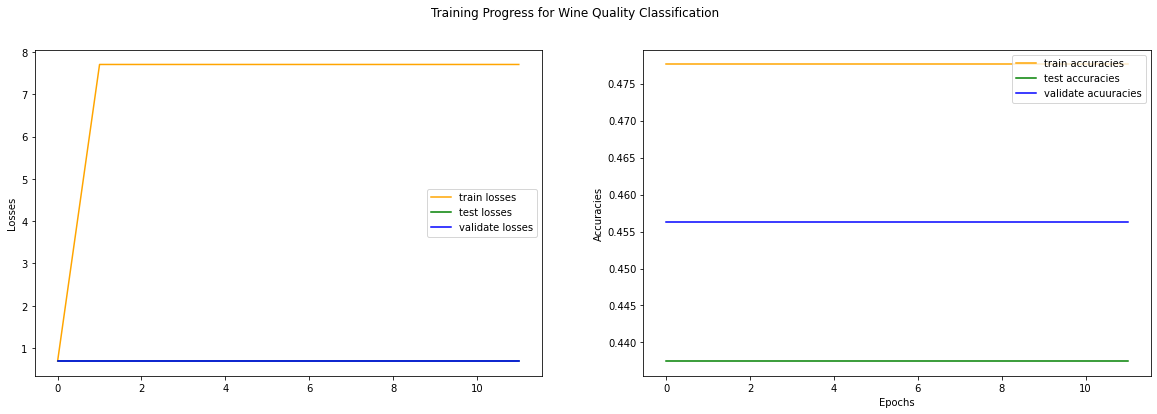

In [874]:
visualize()

## Training on Batch Size of 32

In [876]:
change_batch_size(32, 500, 64)

In [877]:
model = build_model(None)

In [878]:
initialise()
train_loop(model)

 Epoch 0 starting with test-accuracy of 0.562
 Epoch 0 starting with validate-accuracy of 0.544
 Epoch 1 starting with test-accuracy of 0.562
 Epoch 1 starting with validate-accuracy of 0.544
 Epoch 2 starting with test-accuracy of 0.562
 Epoch 2 starting with validate-accuracy of 0.544
 Epoch 3 starting with test-accuracy of 0.562
 Epoch 3 starting with validate-accuracy of 0.544
 Epoch 4 starting with test-accuracy of 0.562
 Epoch 4 starting with validate-accuracy of 0.544
 Epoch 5 starting with test-accuracy of 0.562
 Epoch 5 starting with validate-accuracy of 0.544
 Epoch 6 starting with test-accuracy of 0.562
 Epoch 6 starting with validate-accuracy of 0.544
 Epoch 7 starting with test-accuracy of 0.562
 Epoch 7 starting with validate-accuracy of 0.544
 Epoch 8 starting with test-accuracy of 0.562
 Epoch 8 starting with validate-accuracy of 0.544
 Epoch 9 starting with test-accuracy of 0.562
 Epoch 9 starting with validate-accuracy of 0.544
 Epoch 10 starting with test-accuracy of

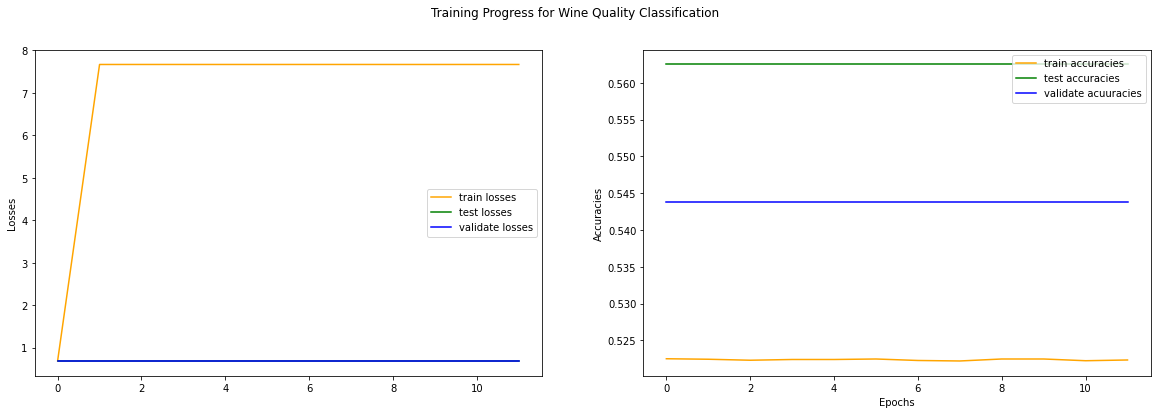

In [879]:
visualize()

A smaller batch size (32) is a compromise between single sample and larger batch size (1024). We randomly take a subset of the data to create a minibatch - this ensures that the average direction of our gradients is much more useful than just single samples, but at the same time by just taking a small subset (generally some order(s) of magnitude smaller than the whole dataset). Also we still have some randomness in choosing our samples, so we better escape local minima!

## SGD with no Momentum + (batch size of 32 from here till the end of the notebook)

In [880]:
change_batch_size(32, 1000, 64)

In [881]:
model = build_model(tf.keras.optimizers.SGD)

In [882]:
initialise()
train_loop(model)

 Epoch 0 starting with test-accuracy of 0.438
 Epoch 0 starting with validate-accuracy of 0.456
 Epoch 1 starting with test-accuracy of 0.438
 Epoch 1 starting with validate-accuracy of 0.456
 Epoch 2 starting with test-accuracy of 0.438
 Epoch 2 starting with validate-accuracy of 0.456
 Epoch 3 starting with test-accuracy of 0.438
 Epoch 3 starting with validate-accuracy of 0.456
 Epoch 4 starting with test-accuracy of 0.438
 Epoch 4 starting with validate-accuracy of 0.456
 Epoch 5 starting with test-accuracy of 0.438
 Epoch 5 starting with validate-accuracy of 0.456
 Epoch 6 starting with test-accuracy of 0.438
 Epoch 6 starting with validate-accuracy of 0.456
 Epoch 7 starting with test-accuracy of 0.438
 Epoch 7 starting with validate-accuracy of 0.456
 Epoch 8 starting with test-accuracy of 0.438
 Epoch 8 starting with validate-accuracy of 0.456
 Epoch 9 starting with test-accuracy of 0.438
 Epoch 9 starting with validate-accuracy of 0.456
 Epoch 10 starting with test-accuracy of

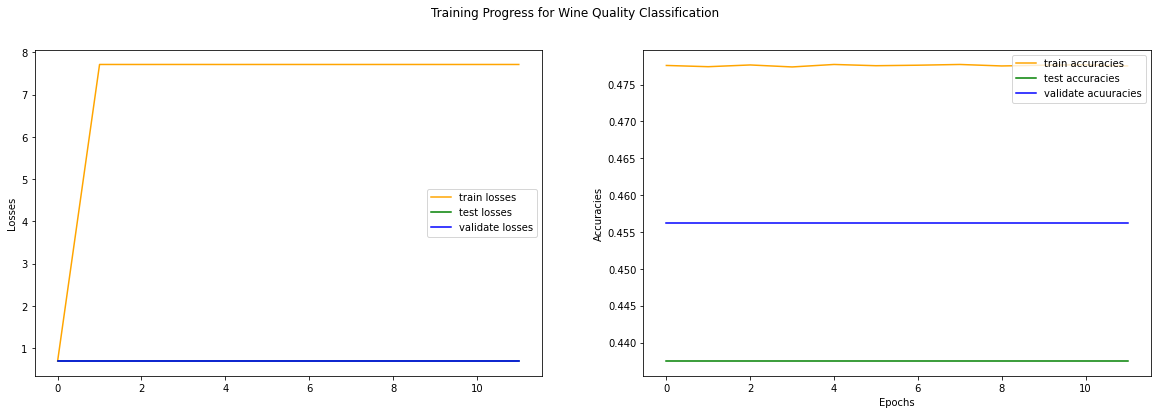

In [883]:
visualize()

## Using SGD with Momentum

In [884]:
model = build_model(tf.keras.optimizers.SGD, momentum=0.95)

In [885]:
initialise()
train_loop(model)

 Epoch 0 starting with test-accuracy of 0.562
 Epoch 0 starting with validate-accuracy of 0.544
 Epoch 1 starting with test-accuracy of 0.562
 Epoch 1 starting with validate-accuracy of 0.544
 Epoch 2 starting with test-accuracy of 0.562
 Epoch 2 starting with validate-accuracy of 0.544
 Epoch 3 starting with test-accuracy of 0.562
 Epoch 3 starting with validate-accuracy of 0.544
 Epoch 4 starting with test-accuracy of 0.562
 Epoch 4 starting with validate-accuracy of 0.544
 Epoch 5 starting with test-accuracy of 0.562
 Epoch 5 starting with validate-accuracy of 0.544
 Epoch 6 starting with test-accuracy of 0.562
 Epoch 6 starting with validate-accuracy of 0.544
 Epoch 7 starting with test-accuracy of 0.562
 Epoch 7 starting with validate-accuracy of 0.544
 Epoch 8 starting with test-accuracy of 0.562
 Epoch 8 starting with validate-accuracy of 0.544
 Epoch 9 starting with test-accuracy of 0.562
 Epoch 9 starting with validate-accuracy of 0.544
 Epoch 10 starting with test-accuracy of

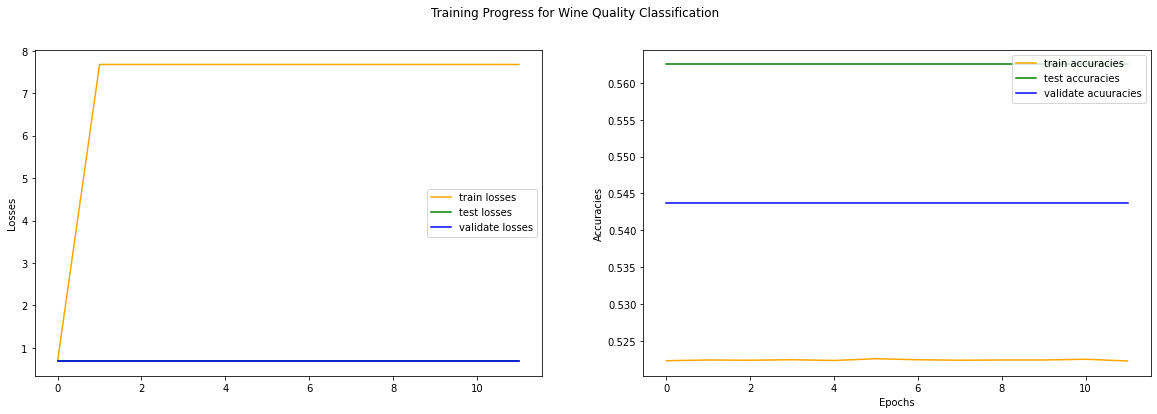

In [886]:
visualize()

There are three major cases where momentum is extremely beneficial to training, in our case these are the two cases:
- When weights end up on a very flat error surface that is only slightly skewed: Momentum allows to gain speed and update weights quicker here
- When we would encounter a local minimum, momentum might allow us to just skip over it

## Using AdamOptimiser

In [887]:
model = build_model(tf.keras.optimizers.Adam)

In [888]:
initialise()
train_loop(model)

 Epoch 0 starting with test-accuracy of 0.438
 Epoch 0 starting with validate-accuracy of 0.456
 Epoch 1 starting with test-accuracy of 0.438
 Epoch 1 starting with validate-accuracy of 0.456
 Epoch 2 starting with test-accuracy of 0.438
 Epoch 2 starting with validate-accuracy of 0.456
 Epoch 3 starting with test-accuracy of 0.438
 Epoch 3 starting with validate-accuracy of 0.456
 Epoch 4 starting with test-accuracy of 0.438
 Epoch 4 starting with validate-accuracy of 0.456
 Epoch 5 starting with test-accuracy of 0.438
 Epoch 5 starting with validate-accuracy of 0.456
 Epoch 6 starting with test-accuracy of 0.438
 Epoch 6 starting with validate-accuracy of 0.456
 Epoch 7 starting with test-accuracy of 0.438
 Epoch 7 starting with validate-accuracy of 0.456
 Epoch 8 starting with test-accuracy of 0.438
 Epoch 8 starting with validate-accuracy of 0.456
 Epoch 9 starting with test-accuracy of 0.438
 Epoch 9 starting with validate-accuracy of 0.456
 Epoch 10 starting with test-accuracy of

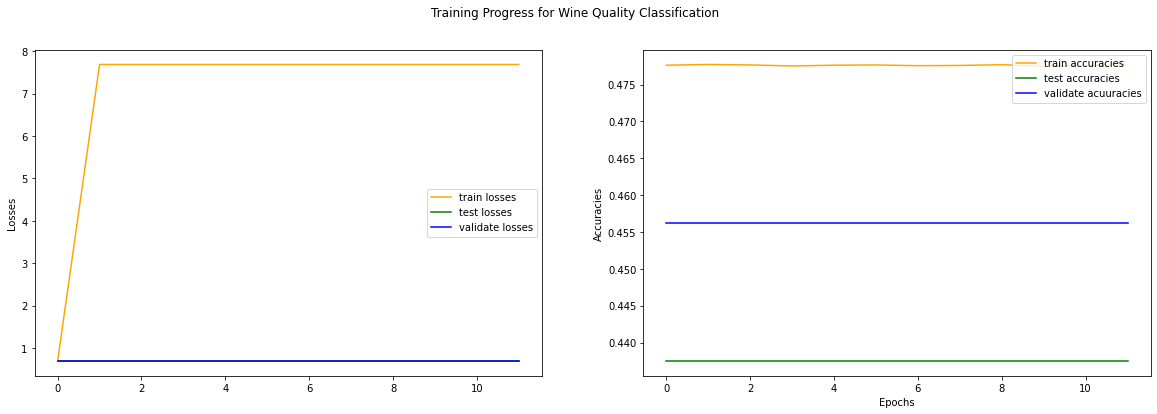

In [889]:
visualize()

## Using AdamOptimiser + Early Stopping

In [890]:
initialise()
train_loop(model, early_stopping=True)

 Epoch 0 starting with test-accuracy of 0.438
 Epoch 0 starting with validate-accuracy of 0.456
 Epoch 1 starting with test-accuracy of 0.438
 Epoch 1 starting with validate-accuracy of 0.456
 Epoch 2 starting with test-accuracy of 0.438
 Epoch 2 starting with validate-accuracy of 0.456
 Epoch 3 starting with test-accuracy of 0.438
 Epoch 3 starting with validate-accuracy of 0.456
 Epoch 4 starting with test-accuracy of 0.438
 Epoch 4 starting with validate-accuracy of 0.456
 Epoch 5 starting with test-accuracy of 0.438
 Epoch 5 starting with validate-accuracy of 0.456
 Epoch 6 starting with test-accuracy of 0.438
 Epoch 6 starting with validate-accuracy of 0.456
 Epoch 7 starting with test-accuracy of 0.438
 Epoch 7 starting with validate-accuracy of 0.456
 Epoch 8 starting with test-accuracy of 0.438
 Epoch 8 starting with validate-accuracy of 0.456
 Epoch 9 starting with test-accuracy of 0.438
 Epoch 9 starting with validate-accuracy of 0.456
 Epoch 10 starting with test-accuracy of

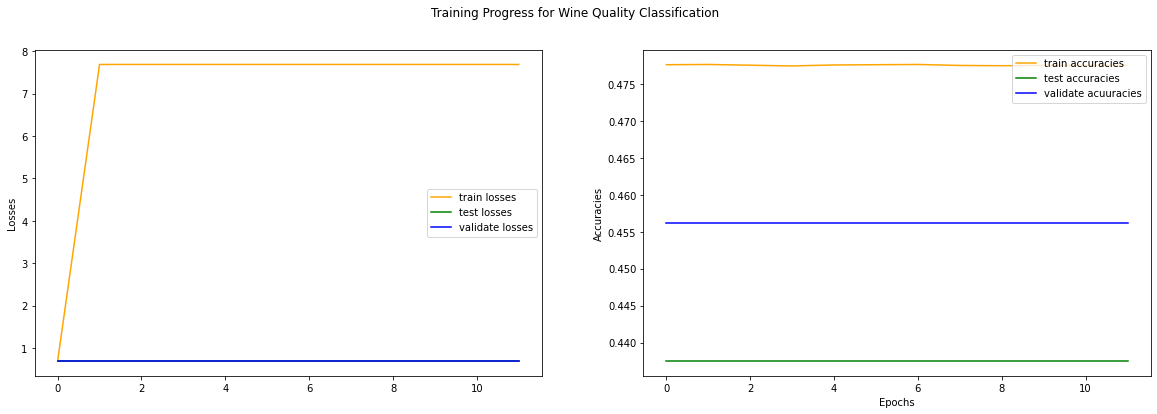

In [891]:
visualize()

## Using regularizer L1 and Adam

In [892]:
model = build_model(tf.keras.optimizers.Adam, kernel_regularizer= regularizers.l1(l1=0.01))

In [893]:
initialise()
train_loop(model)

 Epoch 0 starting with test-accuracy of 0.438
 Epoch 0 starting with validate-accuracy of 0.456
 Epoch 1 starting with test-accuracy of 0.438
 Epoch 1 starting with validate-accuracy of 0.456
 Epoch 2 starting with test-accuracy of 0.438
 Epoch 2 starting with validate-accuracy of 0.456
 Epoch 3 starting with test-accuracy of 0.438
 Epoch 3 starting with validate-accuracy of 0.456
 Epoch 4 starting with test-accuracy of 0.438
 Epoch 4 starting with validate-accuracy of 0.456
 Epoch 5 starting with test-accuracy of 0.438
 Epoch 5 starting with validate-accuracy of 0.456
 Epoch 6 starting with test-accuracy of 0.438
 Epoch 6 starting with validate-accuracy of 0.456
 Epoch 7 starting with test-accuracy of 0.438
 Epoch 7 starting with validate-accuracy of 0.456
 Epoch 8 starting with test-accuracy of 0.438
 Epoch 8 starting with validate-accuracy of 0.456
 Epoch 9 starting with test-accuracy of 0.438
 Epoch 9 starting with validate-accuracy of 0.456
 Epoch 10 starting with test-accuracy of

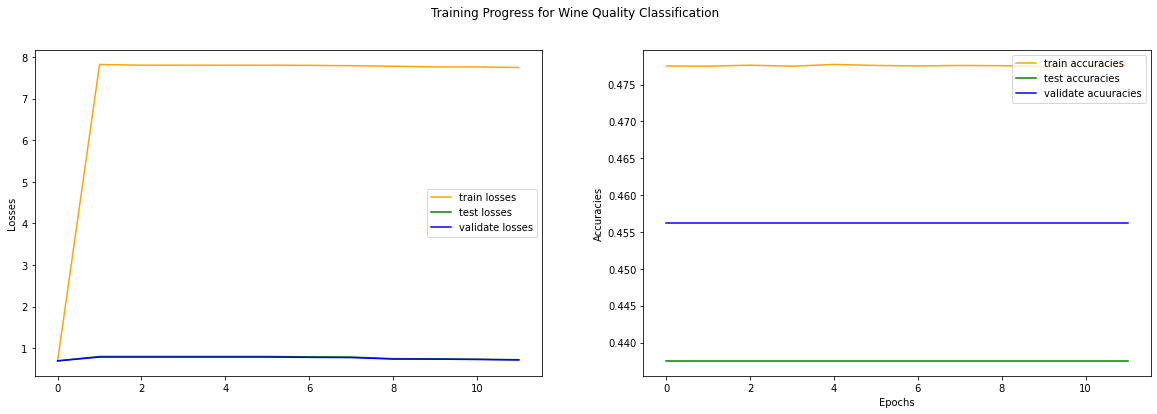

In [894]:
visualize()

## Using regularizer L12 and Adam

In [895]:
model = build_model(tf.keras.optimizers.Adam, kernel_regularizer= regularizers.l2(l2=0.01))

In [896]:
initialise()
train_loop(model)

 Epoch 0 starting with test-accuracy of 0.438
 Epoch 0 starting with validate-accuracy of 0.456
 Epoch 1 starting with test-accuracy of 0.438
 Epoch 1 starting with validate-accuracy of 0.456
 Epoch 2 starting with test-accuracy of 0.511
 Epoch 2 starting with validate-accuracy of 0.51
 Epoch 3 starting with test-accuracy of 0.554
 Epoch 3 starting with validate-accuracy of 0.539
 Epoch 4 starting with test-accuracy of 0.562
 Epoch 4 starting with validate-accuracy of 0.544
 Epoch 5 starting with test-accuracy of 0.562
 Epoch 5 starting with validate-accuracy of 0.544
 Epoch 6 starting with test-accuracy of 0.562
 Epoch 6 starting with validate-accuracy of 0.544
 Epoch 7 starting with test-accuracy of 0.455
 Epoch 7 starting with validate-accuracy of 0.474
 Epoch 8 starting with test-accuracy of 0.549
 Epoch 8 starting with validate-accuracy of 0.541
 Epoch 9 starting with test-accuracy of 0.536
 Epoch 9 starting with validate-accuracy of 0.523
 Epoch 10 starting with test-accuracy of 

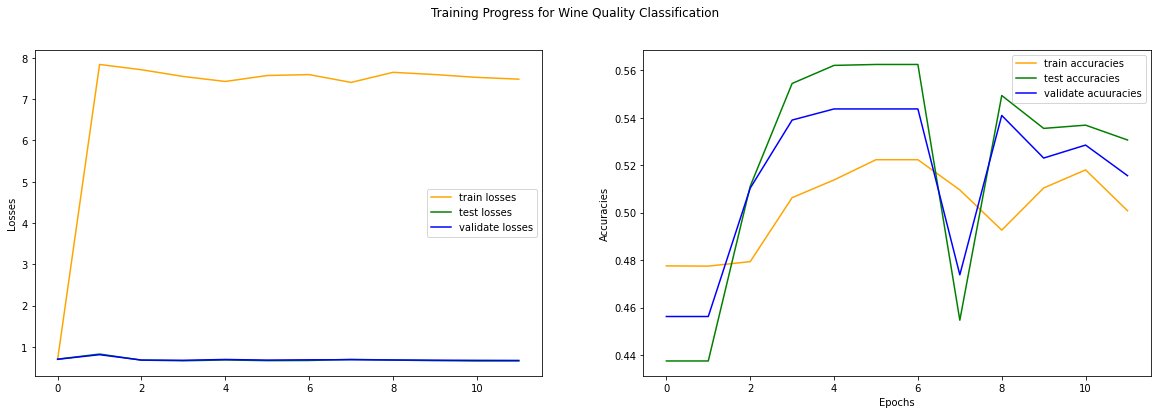

In [897]:
visualize()

## Using regularizer L1 and L2 + Adam

In [898]:
model = build_model(tf.keras.optimizers.Adam, kernel_regularizer= regularizers.l2(l2=0.01))

In [899]:
initialise()
train_loop(model)

 Epoch 0 starting with test-accuracy of 0.558
 Epoch 0 starting with validate-accuracy of 0.543
 Epoch 1 starting with test-accuracy of 0.562
 Epoch 1 starting with validate-accuracy of 0.544
 Epoch 2 starting with test-accuracy of 0.562
 Epoch 2 starting with validate-accuracy of 0.544
 Epoch 3 starting with test-accuracy of 0.562
 Epoch 3 starting with validate-accuracy of 0.544
 Epoch 4 starting with test-accuracy of 0.562
 Epoch 4 starting with validate-accuracy of 0.544
 Epoch 5 starting with test-accuracy of 0.562
 Epoch 5 starting with validate-accuracy of 0.544
 Epoch 6 starting with test-accuracy of 0.562
 Epoch 6 starting with validate-accuracy of 0.544
 Epoch 7 starting with test-accuracy of 0.562
 Epoch 7 starting with validate-accuracy of 0.544
 Epoch 8 starting with test-accuracy of 0.562
 Epoch 8 starting with validate-accuracy of 0.544
 Epoch 9 starting with test-accuracy of 0.562
 Epoch 9 starting with validate-accuracy of 0.544
 Epoch 10 starting with test-accuracy of

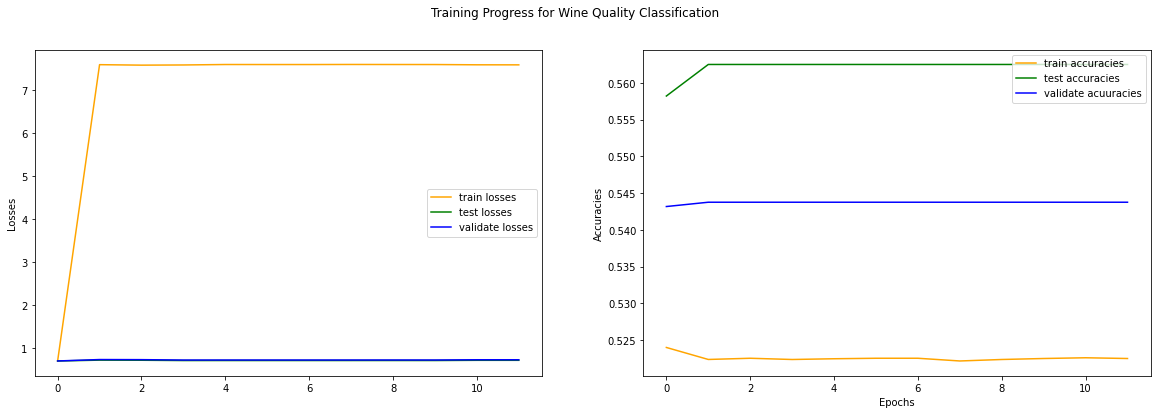

In [900]:
visualize()

After all the different optimisation and regulisation techniques we tried we got an acuurcay of 56.2% on the test data

## Try the normalized Data

In [901]:
initialise()
train_loop(model, norm = True, early_stopping=True)

 Epoch 0 starting with test-accuracy of 0.562
 Epoch 0 starting with validate-accuracy of 0.544
 Epoch 1 starting with test-accuracy of 0.562
 Epoch 1 starting with validate-accuracy of 0.544


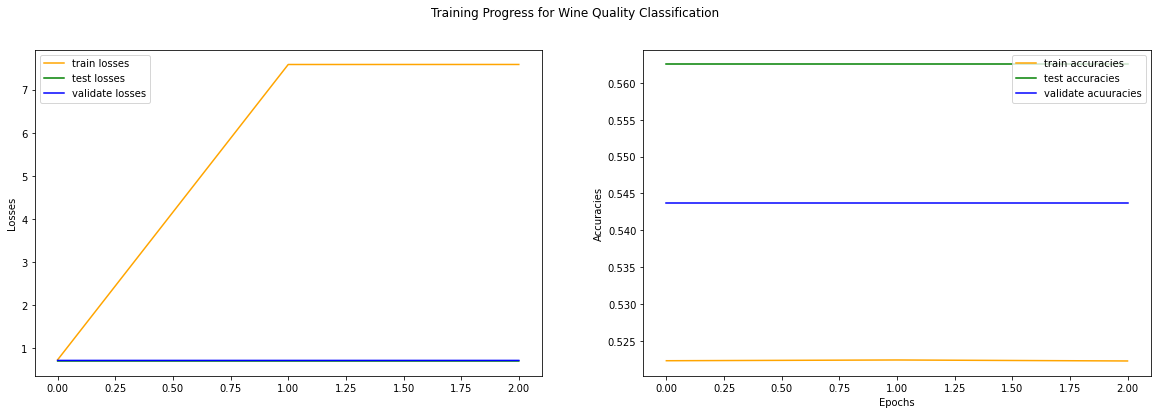

In [902]:
visualize()